In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm

# Helpers

In [2]:
def dem2matrices(dem, n_detectors):
    
    # There might be a way of getting this as a matrix directly from STIM, but I couldn't find it
    # So for now im doing this the improvised way, where it generates the text and I extract data from it
    
    txt = dem.split('\n')[1:-1]
    dims = len(txt)
    errors = np.zeros(dims)
    err_locs = np.zeros((dims, n_detectors))

    for i in range(dims):
        errors[i] = re.findall('\d?\.?\d+e?\-?\d+', txt[i])[0]
        for j in re.findall('D\d', txt[i]):
            err_locs[i, int(j[1])]=1

    return errors, err_locs


def error_rate(errors, errloc, sequence):
    dep = len(sequence)
    err = len(errors)
    errors=errors.reshape(1,-1)

    result = np.stack((np.arange(2**err),) * err, axis=1)

    divide = np.stack((2**np.arange(err)[::-1],)*2**err, axis=0) 

    result=result//divide%2      # Creates binary matrix

    result=result[np.all(np.dot(result,errloc)%2==sequence, axis=1)] #find error combination that agrees with sequence
    return np.sum(np.prod(errors*result+(1-errors)*(1-result), axis=1))

In [3]:
class node:
    
    def __init__(self, circuit):
        self.circuit = circuit
        self.zero = None
        self.one = None
        
    def fail_path(self):
        fails= []
        path = []
        if self.one=='1':
            path = ['1']
            fails.append(path)
        else:
            for p in self.one.fail_path():
                p.append('1')
                fails.append(p)
        if self.zero!='0':
            for p in self.zero.fail_path():
                p.append('0')
                fails.append(p)
        return fails
    
    def fail_paths(self):
        p = []
        circs = []
        for j in self.fail_path():
            p.append(j[::-1])
            
        for j in p:
            node = self
            circ = node.circuit
            for i in j[:-1]:
                if i == '1':
                    circ+=node.one.circuit
                    node = node.one
                if i == '0':
                    circ+=node.zero.circuit
                    node = node.zero
            circs.append(circ)
            
        return p, circs

# QSample

In [4]:
k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):

    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False
    
meas7 = qs.Circuit([ {"measure": {0,1,2,3,4,5,6}} ], noisy=True)

fmx_1 = qs.Circuit([{"init": {8,9}},
                    {"H": {8}},
                    {"CNOT": {(8,3)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,4)}},
                    {"CNOT": {(8,5)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,6)}},
                    {"H": {8}},
                    {"measure": {8,9}}])

fmx_2 = qs.Circuit([{"init": {8,9}},
                    {"H": {8}},
                    {"CNOT": {(8,0)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,2)}},
                    {"CNOT": {(8,4)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,6)}},
                    {"H": {8}},
                    {"measure": {8,9}}])

fmx_3 = qs.Circuit([{"init": {8,9}},
                    {"H": {8}},
                    {"CNOT": {(8,1)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,2)}},
                    {"CNOT": {(8,5)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,6)}},
                    {"H": {8}},
                    {"measure": {8,9}}])

nfs = qs.Circuit([  {"init": {7,8,9}},
                    {"H": {7,8,9}},
                    {"CNOT": {(7,3)}},
                    {"CNOT": {(7,4)}},
                    {"CNOT": {(7,5)}},
                    {"CNOT": {(7,6)}},
                    {"CNOT": {(8,0)}},
                    {"CNOT": {(8,2)}},
                    {"CNOT": {(8,4)}},
                    {"CNOT": {(8,6)}},
                    {"CNOT": {(9,1)}},
                    {"CNOT": {(9,2)}},
                    {"CNOT": {(9,5)}},
                    {"CNOT": {(9,6)}},
                    {"H": {7,8,9}},
                    {"measure": {7,8,9}},
                    {"init": {7,8,9}},
                    {"CNOT": {(3,7)}},
                    {"CNOT": {(4,7)}},
                    {"CNOT": {(5,7)}},
                    {"CNOT": {(6,7)}},
                    {"CNOT": {(0,8)}},
                    {"CNOT": {(2,8)}},
                    {"CNOT": {(4,8)}},
                    {"CNOT": {(6,8)}},
                    {"CNOT": {(1,9)}},
                    {"CNOT": {(2,9)}},
                    {"CNOT": {(5,9)}},
                    {"CNOT": {(6,9)}},
                    {"measure": {7,8,9}} ])

# transitions

def flagged(m):
    v = [0b01] in m or [0b11] in m if m is not None else False
    return v

def flut(m, f1a, f1b, f2a, f2b, f3a, f3b):
    formatter = lambda i,m: str(format(m, '06b')[i])

    sx = ''.join([formatter(i,m) for i in range(3)])
    sz = ''.join([formatter(i,m) for i in range(3,6)])

    if (sz == '001' and flagged([f2a,f2b])) or (sz == '010' and (flagged([f1a,f1b]) or flagged([f3a,f3b]))):
        corrs = {'010': {5, 6}, '001': {4, 6}}
        return qs.Circuit([{'X': corrs[sz]}], noisy=False)
    else: 
        return qs.Circuit([{}], noisy=False)

def rep_check(m):
    # no flag triggered, run second round regardless of syndrome
    return m[-1] == 0b00 or m[-1] == 0b10

def nft_check1(m):
    # flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
    return (m[-1] == 0b01 or m[-1] == 0b11 or (m[-1] == 0b01) or m[-1] == 0b11)

def nft_check2(m1,m2):
    return (m2[-1] == 0b00 and m1[-1] == 0b10) or (m2[-1] == 0b10 and m1[-1] == 0b00) or (m2[-1] == 0b01 or m2[-1] == 0b11)

def syn_check(m1,m2):
    # no flag triggered, syndromes agree in second round
    return (m2[-1] == 0b00 and m1[-1] == 0b00) or (m2[-1] == 0b10 and m1[-1] == 0b10)

functions = {"logErr": logErr, "flut": flut, "rep_check": rep_check, "nft_check1": nft_check1, 'nft_check2': nft_check2, "syn_check": syn_check}

# Define protocol

flagstab = qs.Protocol(check_functions=functions, fault_tolerant=True)
flagstab.add_nodes_from(['X1a', 'X1b', 'X2a', 'X2b', 'X3a', 'X3b', 'nonFT', 'meas'], circuits=[fmx_1, fmx_1, fmx_2,fmx_2, fmx_3,fmx_3, nfs, meas7])
flagstab.add_node('COR')
flagstab.add_edge('START', 'X1a', check='True')

# no flag triggered, run second round regardless of syndrome
flagstab.add_edge('X1a', 'X2a', check='rep_check(X1a)')
flagstab.add_edge('X2a', 'X3a', check='rep_check(X2a)')
flagstab.add_edge('X3a', 'X1b', check='rep_check(X3a)')

# flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
flagstab.add_edge('X1b', 'nonFT', check='nft_check2(X1a,X1b)')
flagstab.add_edge('X2b', 'nonFT', check='nft_check2(X2a,X2b)')
flagstab.add_edge('X3b', 'nonFT', check='nft_check2(X3a,X3b)')

# flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
flagstab.add_edge('X1a', 'nonFT', check='nft_check1(X1a)')
flagstab.add_edge('X2a', 'nonFT', check='nft_check1(X2a)')
flagstab.add_edge('X3a', 'nonFT', check='nft_check1(X3a)')

# no flag triggered, syndromes agree in second round
flagstab.add_edge('X1b', 'X2b', check='syn_check(X1a,X1b)')
flagstab.add_edge('X2b', 'X3b', check='syn_check(X2a,X2b)')
flagstab.add_edge('X3b', 'meas', check='syn_check(X3a,X3b)')

# apply flag correction after nonFT if a flag was triggered
flagstab.add_edge('nonFT', 'COR', check='flut(nonFT[-1], X1a,X1b, X2a,X2b, X3a,X3b)')
flagstab.add_edge('COR', 'meas', check='True')
flagstab.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

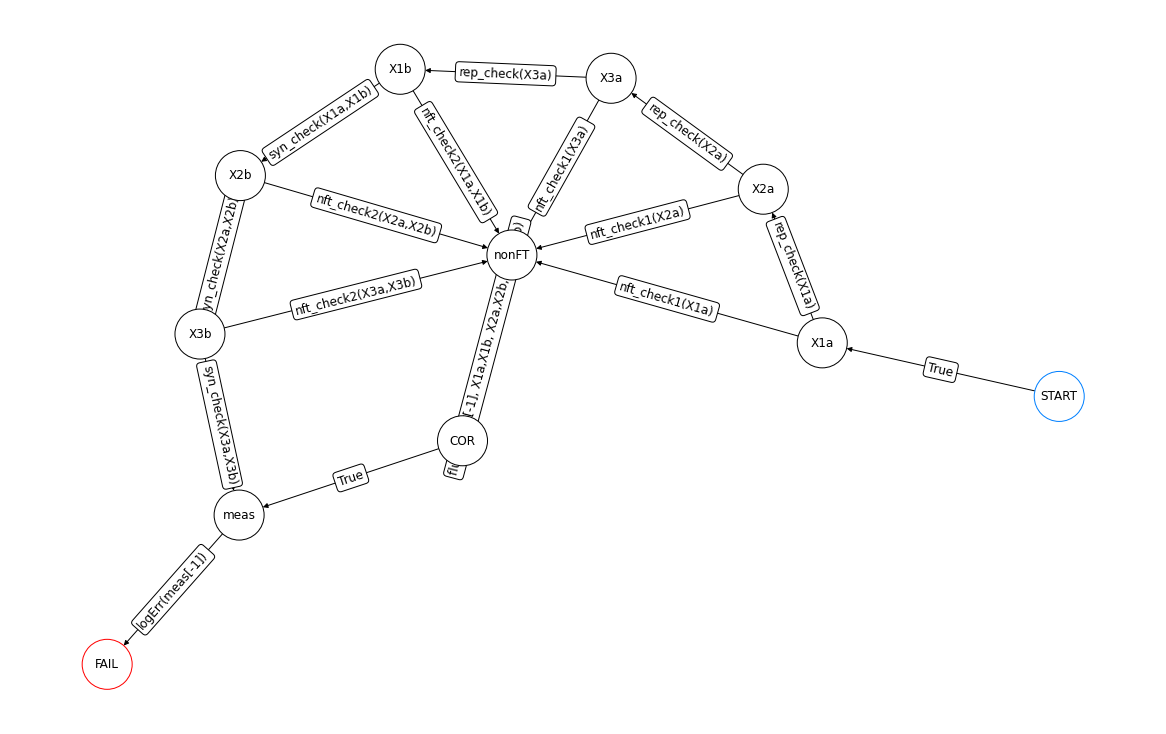

In [5]:
flagstab.draw(figsize=(16,10))

In [6]:
err_model = qs.noise.E1
q_err = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
err_params = {'q': q_err}

In [13]:
begin = time.time()
ss_sam = qs.SubsetSampler(protocol=flagstab, simulator=qs.StabilizerSimulator,  p_max={'q': 0.01}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(2000)
end = time.time()
qsample_time = end-begin

p=('1.00e-02',):   0%|          | 0/2000 [00:00<?, ?it/s]

## STIM

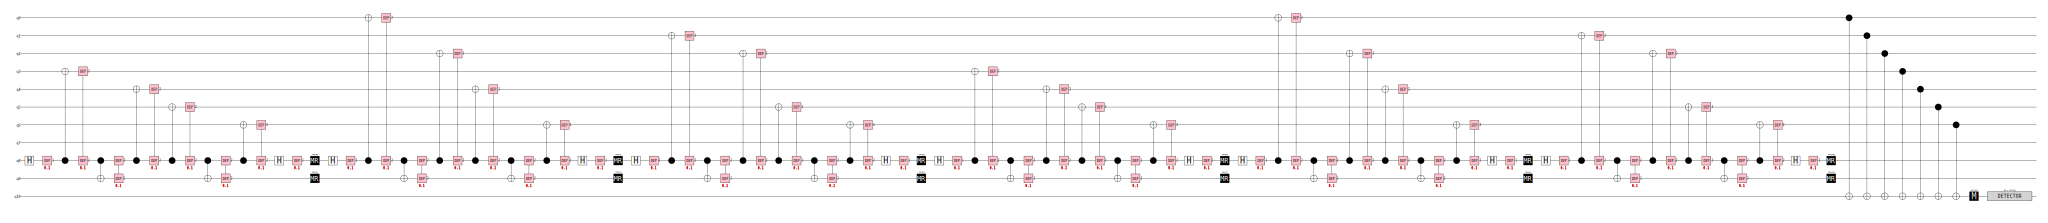

In [8]:
fmx_1 = """

\nH 8\nDEPOLARIZE1({q}) 8\n
CNOT 8 3\nDEPOLARIZE2({q}) 8 3\n
CNOT 8 9\nDEPOLARIZE2({q}) 8 9\n
CNOT 8 4\nDEPOLARIZE2({q}) 8 4\n
CNOT 8 5\nDEPOLARIZE2({q}) 8 5\n
CNOT 8 9\nDEPOLARIZE2({q}) 8 9\n
CNOT 8 6\nDEPOLARIZE2({q}) 8 6\n
H 8\nDEPOLARIZE1({q}) 8\n
MR 8 9\n
"""

fmx_2 = """

\nH 8\nDEPOLARIZE1({q}) 8\n
CNOT 8 0\nDEPOLARIZE2({q}) 8 0\n
CNOT 8 9\nDEPOLARIZE2({q}) 8 9\n
CNOT 8 2\nDEPOLARIZE2({q}) 8 2\n
CNOT 8 4\nDEPOLARIZE2({q}) 8 4\n
CNOT 8 9\nDEPOLARIZE2({q}) 8 9\n
CNOT 8 6\nDEPOLARIZE2({q}) 8 6\n
H 8\nDEPOLARIZE1({q}) 8\n
MR 8 9\n
"""

fmx_3 = """

\nH 8\nDEPOLARIZE1({q}) 8\n
CNOT 8 1\nDEPOLARIZE2({q}) 8 1\n
CNOT 8 9\nDEPOLARIZE2({q}) 8 9\n
CNOT 8 2\nDEPOLARIZE2({q}) 8 2\n
CNOT 8 5\nDEPOLARIZE2({q}) 8 5\n
CNOT 8 9\nDEPOLARIZE2({q}) 8 9\n
CNOT 8 6\nDEPOLARIZE2({q}) 8 6\n
H 8\nDEPOLARIZE1({q}) 8\n
MR 8 9\n
"""

LOG_Z = """\nCNOT 0 10\nCNOT 1 10\nCNOT 2 10\nCNOT 3 10\nCNOT 4 10\nCNOT 5 10\nCNOT 6 10\nM 10\nDETECTOR rec[-1]"""

flag = stim.Circuit((fmx_1+fmx_2+fmx_3+fmx_1+fmx_2+fmx_3+LOG_Z).format(q = 0.1))
flag.diagram('timeline-svg')

In [10]:
errors = []
begin = time.time()
for i in q_err:
    circuit = stim.Circuit((fmx_1+fmx_2+fmx_3+fmx_1+fmx_2+fmx_3+LOG_Z).format(q = i))
    dem = circuit.detector_error_model()
    errors.append((dem2matrices(repr(dem), 1)[0][0])**2)
end = time.time()
stim_time = end-begin

# Comparison

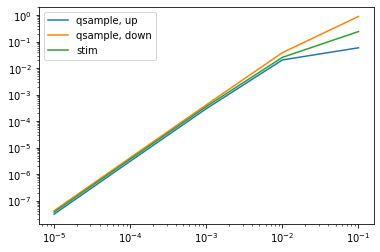

In [14]:
plt.plot(q_err, ss_sam.stats()[0], label = 'qsample, up')
plt.plot(q_err, ss_sam.stats()[2], label = 'qsample, down')
plt.plot(q_err, errors, label = 'stim')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [12]:
print("QSample time: {:.3}s".format(qsample_time))
print("STIM time: {:.3}s".format(stim_time))

QSample time: 5.17s
STIM time: 0.000903s


In [16]:
5.17/0.000903

5725.359911406423